In [69]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
import lightgbm as lgb

In [43]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [45]:
df = pd.read_csv('data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df = df.set_index('Ngày')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Ngày,,,,,,,,,,,,,,,,,,,,,
01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [46]:
data = df[['1','2']]
data

,1,2
Ngày,,
01/01/2021,964.4,964.4
01/02/2021,1019.7,1019.7
01/03/2021,988.4,988.4
01/04/2021,1002.0,1002.0
01/05/2021,1061.5,1061.5
...,...,...
27/12/2021,1002.0,1002.0
28/12/2021,1002.0,1002.0
29/12/2021,1061.5,1061.5


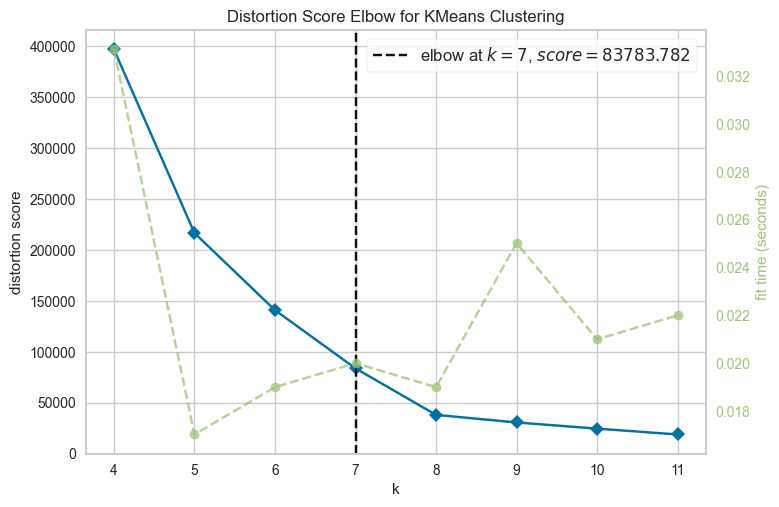

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

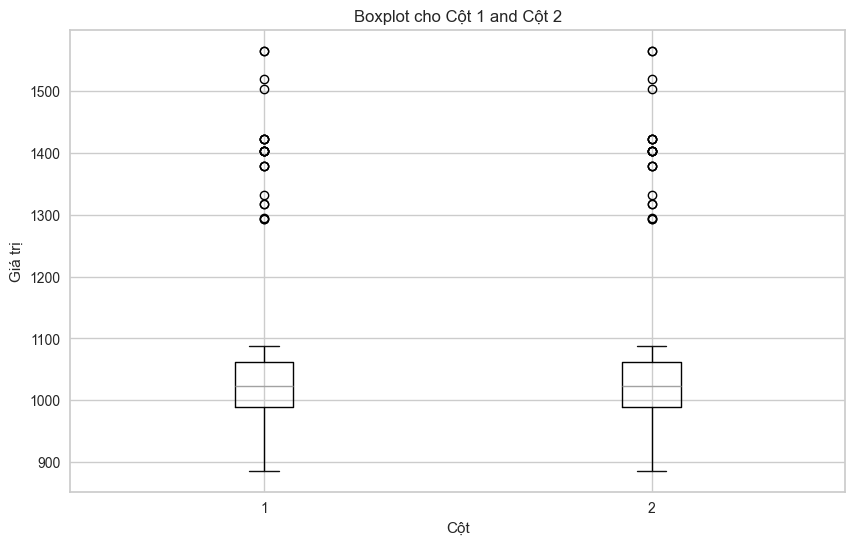

In [48]:
# Tạo boxplot cho cả hai cột
plt.figure(figsize=(10, 6))
data.boxplot()

# Thêm tiêu đề và nhãn trục
plt.title('Boxplot cho Cột 1 and Cột 2')
plt.ylabel('Giá trị')
plt.xlabel('Cột')
plt.show()


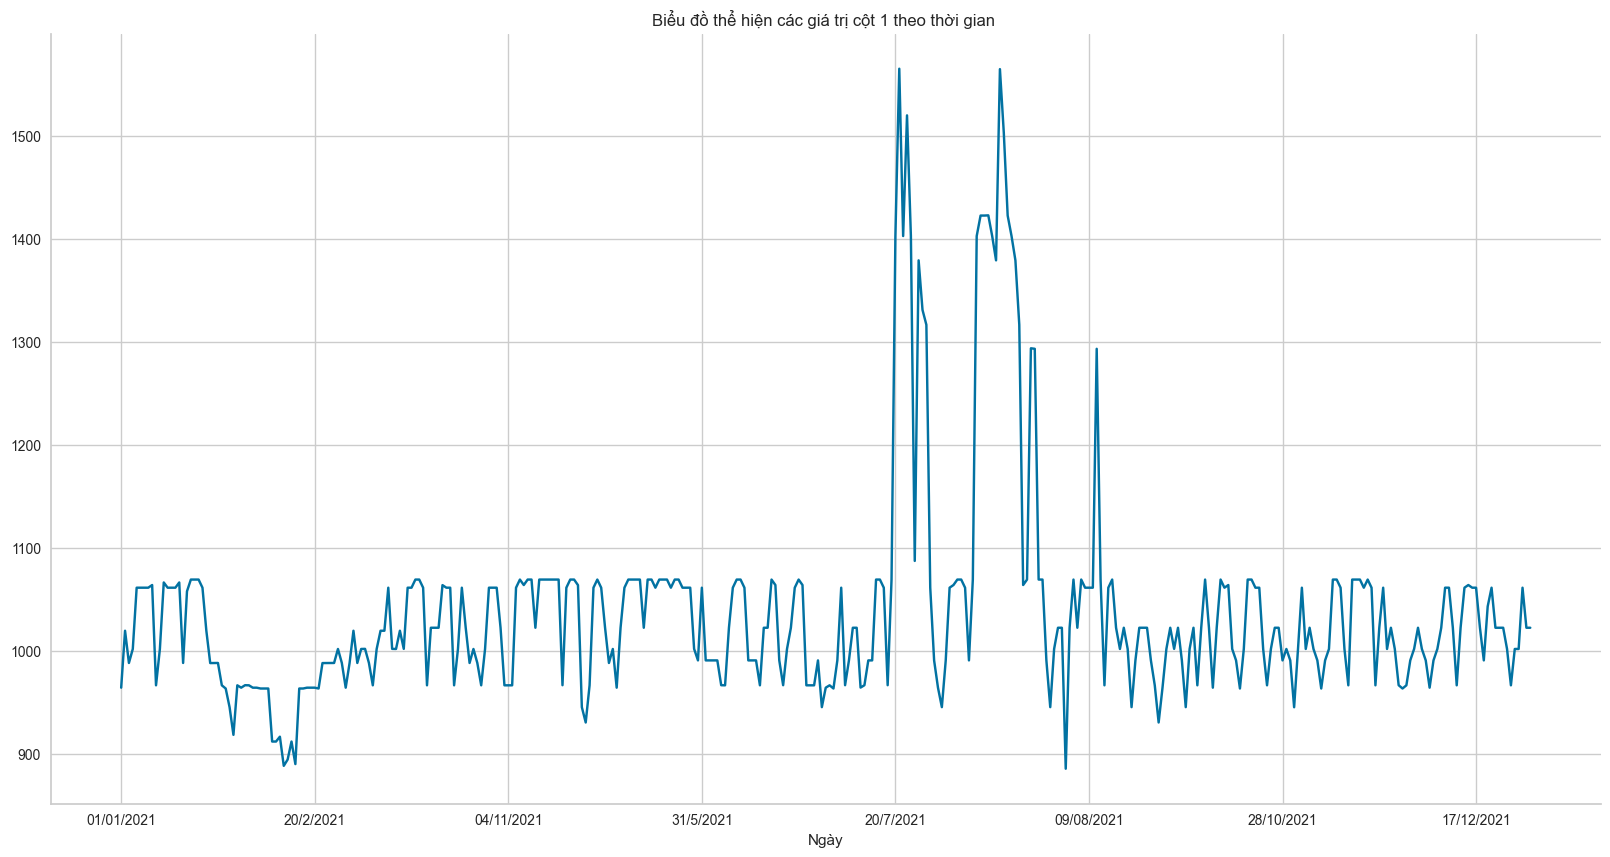

In [51]:
plt.figure(figsize=(20,10))
df['1'].plot(kind='line',figsize=(20,10),title="Biểu đồ thể hiện các giá trị cột 1 theo thời gian ")
plt.gca().spines[['top','right']].set_visible(False)


### Các Model

BayesianGaussianMixture

In [61]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
bgm_preds = BGM.fit_predict(data)

In [75]:
pp=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new1=pd.DataFrame(data) 
df_new1[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new1['preds']=bgm_preds
df_new1['predict_proba']=np.max(pp,axis=1)
df_new1['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new1[(df_new1.preds==n) & (df_new1.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [77]:
from sklearn.model_selection import StratifiedKFold
X_new1=df_new1.loc[train_index]
y=df_new1.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new1.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new1.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 7.49194e-06
[400]	valid_0's multi_logloss: 7.49194e-06
[200]	valid_0's multi_logloss: 7.71975e-06
[400]	valid_0's multi_logloss: 7.71975e-06
[200]	valid_0's multi_logloss: 6.49216e-06
[400]	valid_0's multi_logloss: 6.49216e-06
[200]	valid_0's multi_logloss: 6.40132e-06
[400]	valid_0's multi_logloss: 6.40132e-06
[200]	valid_0's multi_logloss: 7.12493e-06
[400]	valid_0's multi_logloss: 7.12493e-06
[200]	valid_0's multi_logloss: 7.50827e-06
[400]	valid_0's multi_logloss: 7.50827e-06
[200]	valid_0's multi_logloss: 7.45812e-06
[400]	valid_0's multi_logloss: 7.45812e-06
[200]	valid_0's multi_logloss: 7.5083e-06
[400]	valid_0's multi_logloss: 7.5083e-06
[200]	valid_0's multi_logloss: 8.25386e-06
[400]	valid_0's multi_logloss: 8.25386e-06
[200]	valid_0's multi_logloss: 7.32331e-06
[400]	valid_0's multi_logloss: 7.32331e-06
[200]	valid_0's multi_logloss: 1.5107e-05
[400]	valid_0's multi_logloss: 1.5107e-05


In [67]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new1)

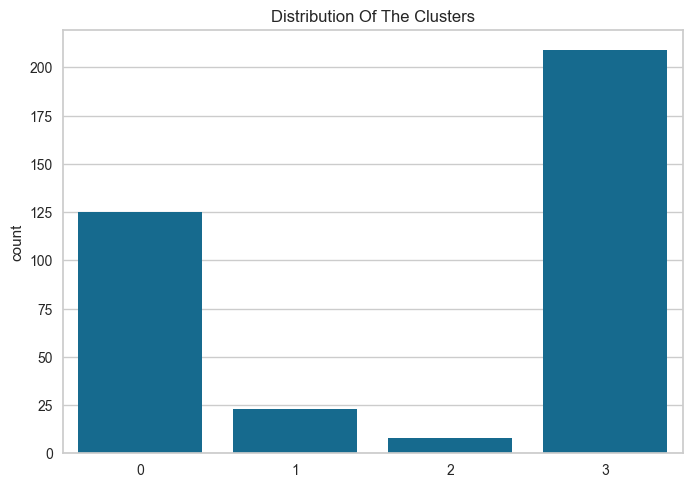

In [70]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

Gaussian

In [59]:
GMM = GaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
gmm_preds = GMM.fit_predict(data)

In [71]:
pp2=GMM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new2=pd.DataFrame(data) 
df_new2[[f'predict_proba_{i}' for i in range(8)]]=pp2 # creating new dataframe columns of probabilites 
df_new2['preds']=gmm_preds
df_new2['predict_proba']=np.max(pp2,axis=1)
df_new2['predict']=np.argmax(pp2,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new2[(df_new2.preds==n) & (df_new2.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [72]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new2.loc[train_index]
y=df_new2.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 1.62721e-05
[400]	valid_0's multi_logloss: 1.61765e-05
[600]	valid_0's multi_logloss: 1.61187e-05
[800]	valid_0's multi_logloss: 1.60789e-05
[1000]	valid_0's multi_logloss: 1.60521e-05
[1200]	valid_0's multi_logloss: 1.6033e-05
[1400]	valid_0's multi_logloss: 1.60186e-05
[1600]	valid_0's multi_logloss: 1.60073e-05
[1800]	valid_0's multi_logloss: 1.59981e-05
[2000]	valid_0's multi_logloss: 1.59903e-05
[2200]	valid_0's multi_logloss: 1.59842e-05
[2400]	valid_0's multi_logloss: 1.59786e-05
[2600]	valid_0's multi_logloss: 1.59741e-05
[2800]	valid_0's multi_logloss: 1.59699e-05
[3000]	valid_0's multi_logloss: 1.59664e-05
[3200]	valid_0's multi_logloss: 1.5963e-05
[3400]	valid_0's multi_logloss: 1.59603e-05
[3600]	valid_0's multi_logloss: 1.59576e-05
[3800]	valid_0's multi_logloss: 1.59552e-05
[4000]	valid_0's multi_logloss: 1.59531e-05
[4200]	valid_0's multi_logloss: 1.5951e-05
[4400]	valid_0's multi_logloss: 1.59492e-05
[4600]	valid_0's multi_logloss: 1.59475

In [73]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new2)

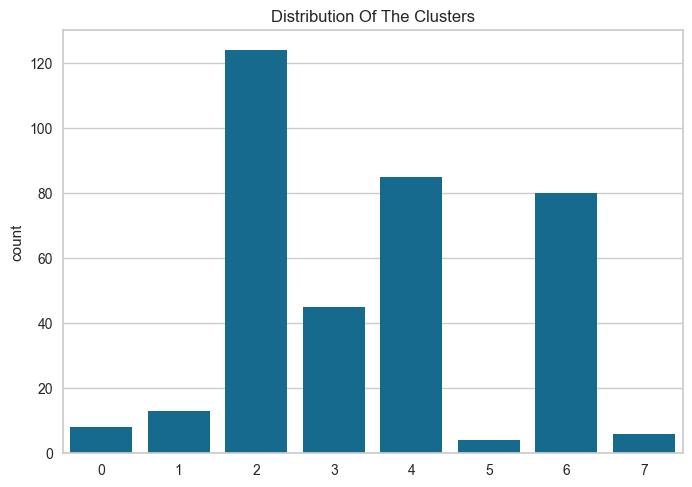

In [74]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()